# Model Evaluation

In [1]:
# Import files 
from pipeline import find_best_model, analyze_best_model
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

reg_df = pd.read_csv('results/evaluation_results/reg-small-grid_ay.csv')
clf_df = pd.read_csv('results/evaluation_results/clf-small-grid_ay.csv')
clf_ly = pd.read_csv('results/evaluation_results/clf-small-grid_ly.csv')

In [2]:
# Look at highest precision across models for last split
clf_14 = clf_df[(clf_df['split']==6) & (clf_df['threshold']==14)]
clf_14.loc[clf_14.groupby(['classifier'])['precision'].idxmax()].sort_values(
    by='precision', ascending=False)

,accuracy,auc,classifier,f1,parameters,precision,recall,split,threshold
1662,0.970808,0.983586,AB,0.883582,"{'algorithm': 'SAMME', 'n_estimators': 1000}",0.791444,1.000000,6,14
1770,0.970808,0.983586,BC,0.883582,{'n_estimators': 100},0.791444,1.000000,6,14
1620,0.970808,0.983586,GB,0.883582,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.791444,1.000000,6,14
1551,0.967814,0.975987,DT,0.871642,"{'criterion': 'entropy', 'max_depth': 50, 'max...",0.780749,0.986486,6,14
1587,0.961826,0.960790,RF,0.847761,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",0.759358,0.959459,6,14
1494,0.958832,0.953192,LR,0.835821,"{'C': 0.1, 'penalty': 'l2'}",0.748663,0.945946,6,14
1779,0.954341,0.941794,LB,0.817910,{},0.732620,0.925676,6,14
1557,0.952844,0.937995,SVM,0.811940,{'C': 0.01},0.727273,0.918919,6,14
1698,0.945359,0.918999,ET,0.782090,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.700535,0.885135,6,14
1506,0.942365,0.911400,KNN,0.770149,"{'algorithm': 'auto', 'n_neighbors': 10, 'weig...",0.689840,0.871622,6,14


In [3]:
#To compare, look at the max precision among models from only last year
clf_14_ly = clf_ly[(clf_ly['split']==6) & (clf_ly['threshold']==14)]
clf_14_ly.loc[clf_14_ly.groupby(['classifier'])['precision'].idxmax()].sort_values(
    by='precision', ascending=False)

,accuracy,auc,classifier,f1,parameters,precision,recall,split,threshold
1665,0.964820,0.968389,AB,0.859701,"{'algorithm': 'SAMME.R', 'n_estimators': 100}",0.770053,0.972973,6,14
1545,0.958832,0.953192,DT,0.835821,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.748663,0.945946,6,14
1620,0.955838,0.945593,GB,0.823881,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.737968,0.932432,6,14
1779,0.955838,0.945593,LB,0.823881,{},0.737968,0.932432,6,14
1560,0.954341,0.941794,SVM,0.817910,{'C': 0.1},0.732620,0.925676,6,14
1773,0.951347,0.934196,BC,0.805970,{'n_estimators': 1000},0.721925,0.912162,6,14
1494,0.951347,0.934196,LR,0.805970,"{'C': 0.1, 'penalty': 'l2'}",0.721925,0.912162,6,14
1587,0.948353,0.926597,RF,0.794030,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",0.711230,0.898649,6,14
1698,0.946856,0.922798,ET,0.788060,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.705882,0.891892,6,14
1503,0.928892,0.877207,KNN,0.716418,"{'algorithm': 'auto', 'n_neighbors': 10, 'weig...",0.641711,0.810811,6,14


As can be seen above, the max precision at 14% for the models leveraging just the last year's data to train is lower than using all previous years; thus, we proceed with the all years models.

In [4]:
# Create df with the max values for each model at threshold 14%, for each split
clf_max_df = clf_df[clf_df['threshold']==14].drop(['parameters'],axis=1)
clf_max_df['max_f1'] = clf_max_df.groupby(
    ['classifier','split','threshold'])['f1'].transform('max')
clf_max_df['max_precision'] = clf_max_df.groupby(
    ['classifier','split','threshold'])['precision'].transform('max')
clf_max_df['max_auc'] = clf_max_df.groupby(
    ['classifier','split','threshold'])['auc'].transform('max')
clf_max_df['max_recall'] = clf_max_df.groupby(
    ['classifier','split','threshold'])['recall'].transform('max')
clf_max_df['max_accuracy'] = clf_max_df.groupby(
    ['classifier','split','threshold'])['accuracy'].transform('max')
clf_max_df.drop(['accuracy','auc','f1','precision','recall'],axis=1,inplace=True)
clf_max_df = clf_max_df.drop_duplicates()

Text(0, 0.5, 'Precision Value at 14%')

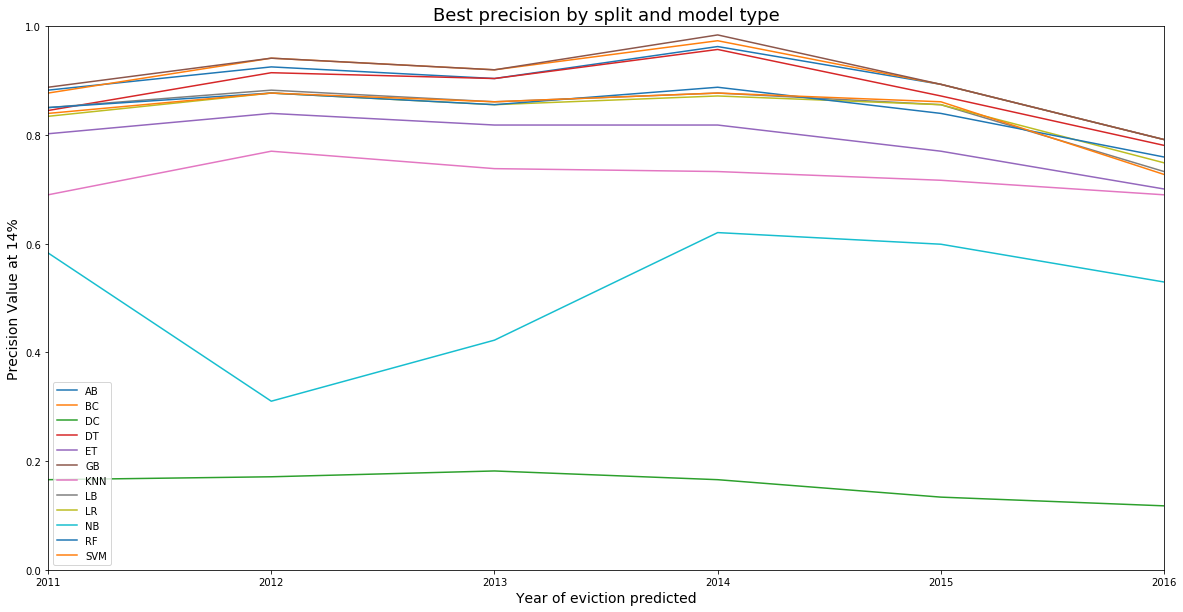

In [5]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)

for key, grp in clf_max_df.groupby(['classifier']):
    ax = grp.plot(ax=ax, kind='line', x='split', y='max_precision', label=key)

plt.Axes.set_xticklabels(ax, [2011, 2012, 2013, 2014, 2015, 2016])
plt.gca().set_ylim([0,1])
plt.title('Best precision by split and model type',fontsize=18)
plt.xlabel('Year of eviction predicted',fontsize=14)
plt.ylabel('Precision Value at 14%',fontsize=14)

In [6]:
# Create df to look at highest performing model within gradient boosting
clf_gb = clf_df[clf_df['classifier']=='GB']
clf_gb = clf_gb[clf_gb['threshold']==14]

clf_gb.loc[clf_gb[clf_gb['split']==6].groupby(['parameters'])['precision'].idxmax()].sort_values(
    by='precision', ascending=False)

,accuracy,auc,classifier,f1,parameters,precision,recall,split,threshold
1626,0.970808,0.983586,GB,0.883582,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.791444,1.000000,6,14
1632,0.970808,0.983586,GB,0.883582,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.791444,1.000000,6,14
1620,0.970808,0.983586,GB,0.883582,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.791444,1.000000,6,14
1650,0.970808,0.983586,GB,0.883582,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.791444,1.000000,6,14
1653,0.970808,0.983586,GB,0.883582,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.791444,1.000000,6,14
1656,0.970808,0.983586,GB,0.883582,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.791444,1.000000,6,14
1638,0.970808,0.983586,GB,0.883582,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.791444,1.000000,6,14
1641,0.970808,0.983586,GB,0.883582,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.791444,1.000000,6,14
1644,0.970808,0.983586,GB,0.883582,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.791444,1.000000,6,14
1617,0.969311,0.979787,GB,0.877612,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.786096,0.993243,6,14


Text(0, 0.5, 'Precision Value at 14%')

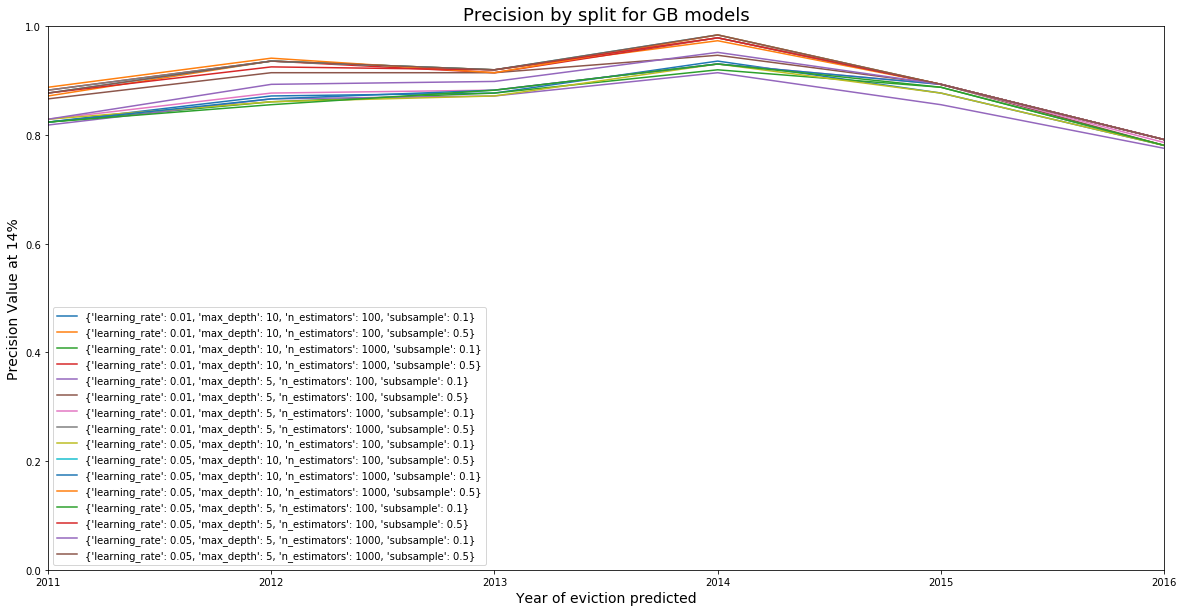

In [7]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)

for key, grp in clf_gb.groupby(['parameters']):
    ax = grp.plot(ax=ax, kind='line', x='split', y='precision', label=key)

plt.Axes.set_xticklabels(ax, [2011, 2012, 2013, 2014, 2015, 2016])
plt.gca().set_ylim([0,1])
plt.title('Precision by split for GB models',fontsize=18)
plt.xlabel('Year of eviction predicted',fontsize=14)
plt.ylabel('Precision Value at 14%',fontsize=14)

## Regression output analysis

In [8]:
reg_16 = reg_df[reg_df['split']==6]
reg_16.loc[reg_16.groupby(['classifier'])['root_mean_squared_error'].idxmax()].sort_values(
    by='root_mean_squared_error')

,classifier,explained_variance,mean_squared_error,parameters,r2,root_mean_squared_error,split
164,DTR,0.896184,7.818988,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.896177,2.796245,6
160,SVR,0.874049,9.486802,{'C': 0.01},0.874032,3.080065,6
174,RFR,0.673344,24.709251,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.671904,4.970840,6


In [9]:
# Create df with the best values for each model for each split
reg_max_df = reg_df.drop(['parameters'],axis=1)
reg_max_df['max_r2'] = reg_max_df.groupby(
    ['classifier','split'])['r2'].transform('max')
reg_max_df['max_explained_var'] = reg_max_df.groupby(
    ['classifier','split'])['explained_variance'].transform('max')
reg_max_df['min_rmse'] = reg_max_df.groupby(
    ['classifier','split'])['root_mean_squared_error'].transform('min')
reg_max_df['min_mean_squared_error'] = reg_max_df.groupby(
    ['classifier','split'])['mean_squared_error'].transform('min')
reg_max_df.drop(['explained_variance','r2','mean_squared_error','root_mean_squared_error'],
                axis=1,inplace=True)
reg_max_df = reg_max_df.drop_duplicates()

Text(0, 0.5, 'RMSE')

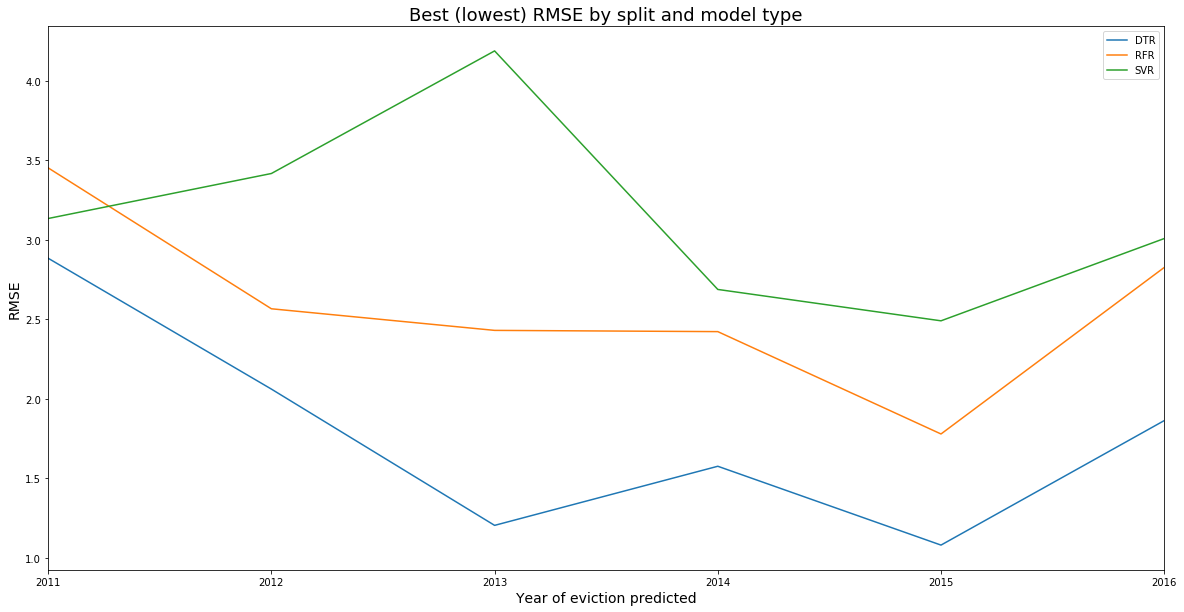

In [10]:
# Plot best RMSE over time for each model
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)

for key, grp in reg_max_df.groupby(['classifier']):
    ax = grp.plot(ax=ax, kind='line', x='split', y='min_rmse', label=key)

plt.Axes.set_xticklabels(ax, [2011, 2012, 2013, 2014, 2015, 2016])
plt.title('Best (lowest) RMSE by split and model type',fontsize=18)
plt.xlabel('Year of eviction predicted',fontsize=14)
plt.ylabel('RMSE',fontsize=14)

# Interpretation of Best Models
Our baseline is a Logistic Regression classifier with a single feature
(evictions the previous year) and the default parameters.

Our best classifier is a Gradient Boosting with the following parameters:
'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5.
Our best regressor is a Decision Tree with the following parameters:
'max_depth': 50, 'max_features': None, 'min_samples_split': 10.

This notebook produces additional deliverables upon selecting these models.
This includes the following:

For the baseline classifier:
- A "stump" one-level decision tree ('stump.png')``
- The list of the top 14% of selected blocks ('baseline_selected_blocks.csv')
- The precision-recall curves ('baseline_pr_curve.png')

For the best classifier:
- The list of the top 14% selected blocks ('clf_selected_blocks.csv')
- The list of feature importance ('clf_feature_importance.csv')
- The precision-recall curves ('clf_pr_curve.png')

For the best regressor:
- The list of the top 14% selected blocks ('reg_selected_blocks.csv')
- The list of feature importance ('reg_feature_importance.csv')

And to compare the best classifier and best regressor:
- The list of the top 14% blocks based on actual evictions, and the predictions
  yielded from the best classifier and best regressor for these blocks
  ('clf_reg_comparison.csv')

## Environment Setup

In [11]:
from os import path
from IPython.display import Image
import pipeline
from pipeline import clean

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

## Pipeline Setup

In [12]:
df = pd.read_csv('data/final_merged_df.csv')
splits = pipeline.split_all_years(df, colname='year_evictions')
cleaned_splits = [pipeline.clean_split(split) for split in splits]
labeled_splits = [pipeline.label(split, lower_bound=15, drop_column=True)
                  for split in cleaned_splits]

test_year = 2016
splits_dict = {2011:0, 2012:1, 2013:2, 2014:3, 2015: 4, 2016: 5}
train_df, test_df = labeled_splits[splits_dict[test_year]]

## Baseline Classifier
Logistic Regression classifier with a single feature (evictions the previous year) and the default parameters.

In [13]:
params = {}
baseline_model, baseline_scores = pipeline.run_one_clf(
    train_df, test_df, 'LB', params, col_blacklist=['GEOID', 'year_evictions'])

#### "Stump" Decision Tree

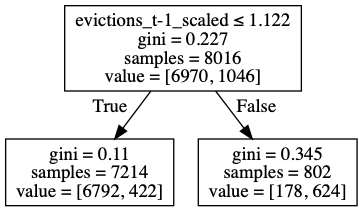

In [14]:
params = {'max_depth': 1}
dtree, dtree_scores = pipeline.run_one_clf(
    train_df, test_df, 'DT', params, col_blacklist=['GEOID', 'year_evictions'])
analyze_best_model.plot_tree(dtree, test_df, 'stump.png', test_year )
Image(filename=path.join('results', str(test_year), 'stump.png'))

#### Selected Blocks

In [15]:
selected_blocks = analyze_best_model.select_k_blocks(
    baseline_scores, .14 , ['score'], ['GEOID', 'label'])
selected_blocks.to_csv(
    path.join('results', str(test_year), 'baseline_selected_blocks.csv'), index=False)
selected_blocks.head(10)

,GEOID,label
6215,421010273003,1
6978,421010301002,1
8315,421010346001,1
5389,421010243002,1
6103,421010268001,1
8511,421010353021,1
5711,421010257001,1
8938,421010373003,1
8385,421010348021,1
8658,421010361001,1


#### Precision-Recall Curves

<Figure size 432x288 with 0 Axes>

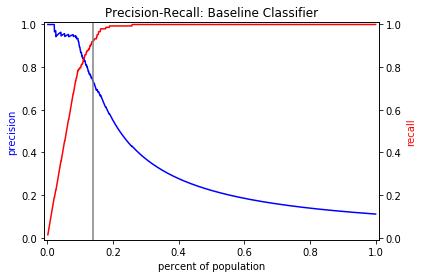

In [16]:
pipeline.plot_precision_recall_n(
    baseline_scores, .14, 'Precision-Recall: Baseline Classifier', 
    'baseline_pr_curve.png', test_year)

## Best Classifier
Gradient Boosting with the following parameters: 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5.

In [17]:
params = {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5}
best_clf, clf_scores = pipeline.run_one_clf(
    train_df, test_df, 'GB', params, col_blacklist=['GEOID', 'year_evictions'])

#### Selected Blocks

In [18]:
selected_blocks = analyze_best_model.select_k_blocks(clf_scores, .14 , ['score'], ['GEOID', 'label'])
selected_blocks.to_csv(path.join('results', str(test_year), 'clf_selected_blocks.csv'), index=False)
selected_blocks.head(10)

,GEOID,label
8658,421010361001,1
6215,421010273003,1
4892,421010206001,1
3002,421010122012,1
8679,421010362011,1
6446,421010279021,1
8385,421010348021,1
4304,421010179004,1
5389,421010243002,1
6103,421010268001,1


#### Precision-Recall Curves

<Figure size 432x288 with 0 Axes>

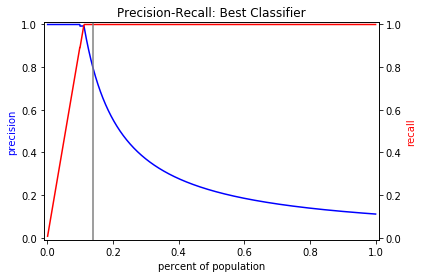

In [19]:
pipeline.plot_precision_recall_n(
    clf_scores, .14, 'Precision-Recall: Best Classifier', 'clf_pr_curve.png', test_year)

#### Feature Importance

In [20]:
importance = analyze_best_model.feature_importance(best_clf, test_df.columns)
importance.to_csv(path.join('results', str(test_year), 'clf_feature_importance.csv'), index=False)
importance.head(10).round(2)

,feature,importance
67,evictions_t-1_scaled,0.49
3,evictions_change_1,0.17
68,evictions_t-2_scaled,0.17
4,evictions_change_2,0.11
69,evictions_t-5_scaled,0.01
5,evictions_change_5,0.01
75,renter_occupied_household_size_scaled,0.00
10,for_rent_units_percent,0.00
81,for_rent_units_scaled,0.00
82,num_af_am_alone_scaled,0.00


## Best Regressor
Decision Tree with the following parameters: 'max_depth': 50, 'max_features':
None, 'min_samples_split': 10.

In [21]:
train_df, test_df = cleaned_splits[splits_dict[test_year]]
params = {'max_depth': 50, 'max_features': None, 'min_samples_split': 10}
best_reg, reg_scores = pipeline.run_one_reg(
    train_df, test_df, 'DTR', params, col_blacklist=['GEOID', 'year_evictions'])

#### Selected Blocks

In [22]:
selected_blocks = analyze_best_model.select_k_blocks(reg_scores, .14 , ['pred_evictions'], ['GEOID', 'pred_evictions'])
selected_blocks.to_csv(path.join('results', str(test_year), 'reg_selected_blocks.csv'), index=False)
selected_blocks.head(10)

,GEOID,pred_evictions
6215,421010273003,75.500000
6978,421010301002,69.333333
8315,421010346001,54.333333
5389,421010243002,53.375000
5711,421010257001,53.375000
6103,421010268001,53.375000
3002,421010122012,51.666667
4892,421010206001,51.666667
8658,421010361001,51.666667
8511,421010353021,44.428571


#### Feature Importance

In [23]:
importance = analyze_best_model.feature_importance(best_reg, test_df.columns)
importance.to_csv(path.join('results', str(test_year), 'reg_feature_importance.csv'), index=False)
importance.head(10).round(2)

,feature,importance
67,evictions_t-1_scaled,0.72
3,evictions_change_1,0.21
21,evictions_change_1_binary,0.04
68,evictions_t-2_scaled,0.02
5,evictions_change_5,0.00
23,evictions_change_5_binary,0.00
69,evictions_t-5_scaled,0.00
4,evictions_change_2,0.00
8,total_renter_households_percent,0.00
84,num_white_alone_scaled,0.00


## Comparing Best Classifier and Best Regressor

In [ ]:
comparison = analyze_best_model.clf_reg_comparison(
    best_clf, clf_scores, best_reg, reg_scores, test_df, .14)
comparison.to_csv(path.join('results', str(test_year), 'clf_reg_comparison.csv'), index=False)
comparison.head(10).round(2)

,GEOID,actual_evictions,clf_pred_score,reg_pred_evictions
0,421010273003,128.0,1.0,75.50
1,421010301002,83.0,1.0,69.33
2,421010361001,78.0,1.0,51.67
5,421010346001,58.0,1.0,54.33
3,421010243002,58.0,1.0,53.38
4,421010268001,58.0,1.0,53.38
6,421010257001,51.0,1.0,53.38
7,421010206001,50.0,1.0,51.67
8,421010353021,49.0,1.0,44.43
9,421010348021,47.0,1.0,38.57


## Comparing Selected Blocks over Splits

In [ ]:
df_11 = pd.read_csv('results/2011/clf_selected_blocks.csv')
df_12 = pd.read_csv('results/2012/clf_selected_blocks.csv')
df_13 = pd.read_csv('results/2013/clf_selected_blocks.csv')
df_14 = pd.read_csv('results/2014/clf_selected_blocks.csv')
df_15 = pd.read_csv('results/2015/clf_selected_blocks.csv')
df_16 = pd.read_csv('results/2016/clf_selected_blocks.csv')

final_list = []
for n in [187, 100, 50]: 
    l = [n]
    for df in [df_11, df_12, df_13, df_14, df_15, df_16]:
        l.append(len(set(df['GEOID'][:n]).intersection(set(df_16['GEOID'])))/len(set(df_16['GEOID'][:n])))
    final_list.append(l)
comparison = pd.DataFrame(final_list, columns=['top_n', '2011', '2012', '2013', '2014', '2015', '2016']).round(2)
comparison.to_csv('results/selected_blocks_comparison.csv', index=False)
comparison

,top_n,2011,2012,2013,2014,2015,2016
0,187,0.66,0.67,0.65,0.66,0.67,1.0
1,100,0.86,0.85,0.81,0.80,0.81,1.0
2,50,0.88,0.90,0.86,0.94,0.92,1.0


# Bias and Fairness
Note that as shown above, for our best models, recall at 14% is 100%, meaning there are no false negatives at this thresholds. Thus, to provide a more fruitful understanding of bias and fairness in our models, we're considering bias and fairness (specifically through false negative and false omission rates) at 10% to make this analysis more meaningful. Specifically, this reflects how our models may be biased in the case of even more limited resources than the 14% that we're assuming.  

## Setup

In [ ]:
import numpy as np
from pipeline import BiasCop

df = pd.read_csv('data/final_merged_df.csv')

splits = pipeline.split_all_years(df, colname='year_evictions')
cleaned_splits = [pipeline.clean_split(split) for split in splits]
labeled_splits = [pipeline.label(split, lower_bound=14, drop_column=False)
                  for split in cleaned_splits]

train_df, test_df = labeled_splits[-1]

## Best Classifier
Gradient Boosting with the following parameters: 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5.

In [ ]:
params = {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5}
_, clf_pred_df = pipeline.run_one_clf(
train_df,
    test_df,
    'GB',
    params,
    col_blacklist=['GEOID', 'year_evictions', 'evictions']
)

# Label based on scores
labeled_clf_pred_df = pipeline.label_df_pct(
    clf_pred_df, 10, sort_by_var='score', label_col='pred_label')

In [ ]:
clf_cop = BiasCop(labeled_clf_pred_df, score_col='pred_label')
clf_cop.xtabs()

model_id, score_thresholds 1 {'rank_abs': [133]}


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,1,binary 0/1,133,majority_demo,af_am_alone,0.712766,1.0,0.060811,0.0,0.0,0.287234,0.939189,1.0,67,444,0.503759,0.131115,0,27,417,67,94,417,511,1336,0.183953
1,1,binary 0/1,133,majority_demo,hisp,0.400000,1.0,0.054545,0.0,0.0,0.600000,0.945455,1.0,2,55,0.015038,0.035088,0,3,52,2,5,52,57,1336,0.087719
2,1,binary 0/1,133,majority_demo,mixed,0.805970,1.0,0.038576,0.0,0.0,0.194030,0.961424,1.0,54,337,0.406015,0.138107,0,13,324,54,67,324,391,1336,0.171355
3,1,binary 0/1,133,majority_demo,white_alone,0.555556,1.0,0.021798,0.0,0.0,0.444444,0.978202,1.0,10,367,0.075188,0.026525,0,8,359,10,18,359,377,1336,0.047745


In [ ]:
clf_cop.plot_group_metric('fnr')

In [ ]:
clf_cop.plot_disparity('fnr_disparity')

In [ ]:
clf_cop.plot_fairness('for')

## Best Regressor
Decision Tree with the following parameters: 'max_depth': 50, 'max_features':
None, 'min_samples_split': 10.

In [ ]:
params = {'max_depth': 50, 'max_features': None, 'min_samples_split': 10}
_, reg_pred_df = pipeline.run_one_reg(
    train_df,
    test_df,
    'DTR',
    params,
    label_col='evictions',
    col_blacklist=['GEOID', 'year_evictions', 'label']
)

# Have to turn our predicted scores into a binary label
labeled_reg_pred_df = pipeline.label_df_pct(
    reg_pred_df, 10, sort_by_var='pred_evictions', label_col='pred_label')
reg_cop = BiasCop(labeled_reg_pred_df, score_col='pred_label')
reg_cop.xtabs()

In [ ]:
reg_cop.plot_group_metric('fnr')

In [ ]:
reg_cop.plot_disparity('fnr_disparity')

In [ ]:
reg_cop.plot_fairness('fnr')

In [ ]:
reg_cop.plot_fairness('for')